## 1. Введение

Целью проекта является анализ бизнес-показателей развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев бизнес постоянно нес убытки. Необходимо разобраться, в чем причина и как это исправить. 

В нашем распоряжении лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Необходимо изучить люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отричательно влияют на привлечение пользователей.

#### Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):


* `User Id` — уникальный идентификатор пользователя

* `Device` — категория устройства пользователя

* `Session start` — дата и время начала сессии

* `Session End` — дата и время окончания сессии

* `Channel` — идентификатор рекламного источника, из которого пришел пользователь

* `Region` - страна пользователя

Таблица orders (информация о заказах):


* `User Id` — уникальный id пользователя, который сделал заказ

* `Event Dt` — дата и время покупки

* `Revenue` — выручка

Таблица costs (информация о затратах на маркетинг):


* `Channel` — идентификатор рекламного источника

* `Dt` — дата

* `Costs` — затраты на этот рекламный источник в этот день

## 2. Импорт данных и предобработка

Импортируем данные и подготовим их к анализу. Проверим на наличие пропусков и дубликатов, приведем данные к нужным типам. 

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

In [4]:
# импортируем данные
visits = pd.read_csv('/datasets/visits_info.csv')
orders = pd.read_csv('/datasets/orders_info.csv')
costs = pd.read_csv('/datasets/costs_info.csv')

Напишем функцию, которая выводит первые пять строк таблицы, информацию о таблице, а также количество пропусков и дубликатов.

In [5]:
# определение функции info
def info(data):
    display(data.head())
    print('Информация о таблице')
    display(data.info())
    print('Количество пропусков')
    display(data.isnull().sum())
    print('Количество дубликатов')
    display(data.duplicated().sum())

In [6]:
# применяем info ко всем таблицам
for i in list([visits,orders,costs]):
    info(i)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,01.05.2019 02:36,01.05.2019 02:45
1,278965908054,United States,iPhone,organic,01.05.2019 04:46,01.05.2019 04:47
2,590706206550,United States,Mac,organic,01.05.2019 14:09,01.05.2019 15:32
3,326433527971,United States,Android,TipTop,01.05.2019 00:29,01.05.2019 00:54
4,349773784594,United States,Mac,organic,01.05.2019 03:33,01.05.2019 03:57


Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
User Id          309901 non-null int64
Region           309901 non-null object
Device           309901 non-null object
Channel          309901 non-null object
Session Start    309901 non-null object
Session End      309901 non-null object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

Количество пропусков


User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64

Количество дубликатов


0

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
User Id     40212 non-null int64
Event Dt    40212 non-null object
Revenue     40212 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

Количество пропусков


User Id     0
Event Dt    0
Revenue     0
dtype: int64

Количество дубликатов


0

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


Информация о таблице
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
dt         1800 non-null object
Channel    1800 non-null object
costs      1800 non-null float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Количество пропусков


dt         0
Channel    0
costs      0
dtype: int64

Количество дубликатов


0

Из полученной информации о таблицах видно, что ни в одной из таблиц нет ни пропусков, ни дубликатов. Данные почти готовы к анализу, осталось привести в порядок названия столбцов и привести все столбцы, в которых содержатся даты к типу *datetime*.

* **Обработка названий столбцов**

Приведем названия столбцов к нижнему регистру и заменим пробелы на нижнее подчёркивание. Чтобы обработать все таблицы сразу используем цикл.

In [7]:
# обработка названий столбцов
for i in list([visits,orders,costs]):
    i.columns = [x.lower().replace(' ','_')
    for x in i.columns.values]
    print(i.columns)

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')
Index(['user_id', 'event_dt', 'revenue'], dtype='object')
Index(['dt', 'channel', 'costs'], dtype='object')


* **Изменение типов данных в столбцах с датами на datetime**

In [8]:
# переводим столбцы с датами в datetime
visits['session_start'] = pd.to_datetime(visits['session_start'],format='%d.%m.%Y %H:%M')
visits['session_end'] = pd.to_datetime(visits['session_end'],format='%d.%m.%Y %H:%M')
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt'])

**Вывод**
Данные полностью обработаны и готовы к анализу: пропуски и дубликаты отсутствуют, названия столбцов корректны, данные в столбцах с датами приведены к типу datetime.

## 3. Исследовательский анализ данных

### 3.1 Построение пользовательских профилей

Для дальнейшего анализа нужно создать пользовательские профили, содержащие в себе информацию о пользователях приложения.

Чтобы создать профили пользователей, определим функцию get_profiles, которая принимает на вход две таблицы, группирует пользователей по id и для каждого пользователя определяет: 
* дату и время первой сессии - **first_ts**, 
* рекламный источник, из которого пользователь пришел в первый раз - **channel**,
* устройство, с которого пользователь заходил в приложение - **device**,
* страна пользователя - **region**,
* дата первого посещения - **dt**,
* месяц первого посещения - **month**,
* совершал ли пользователь покупки **payer**

In [9]:
#функция для создания пользовательских профилей
def get_profiles(sessions, orders):

    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # проверка, есть ли ID пользователей из profiles в orders
    profiles['payer'] =  profiles['user_id'].isin(orders['user_id'].unique())

    return profiles

In [10]:
# построение профилей пользователей
profiles = get_profiles(visits,orders)
profiles

,user_id,first_ts,channel,device,region,dt,month,payer
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False
...,...,...,...,...,...,...,...,...
150003,999956196527,2019-09-28 08:33:00,TipTop,iPhone,United States,2019-09-28,2019-09-01,False
150004,999975439887,2019-10-21 00:35:00,organic,PC,UK,2019-10-21,2019-10-01,False
150005,999976332130,2019-07-23 02:57:00,TipTop,iPhone,United States,2019-07-23,2019-07-01,False
150006,999979924135,2019-09-28 21:28:00,MediaTornado,PC,United States,2019-09-28,2019-09-01,False


Найдем минимальную и максимальную дату привлечения пользователей:

In [11]:
print('Минимальная дата привлечения пользователей:', profiles['dt'].min())
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


Сгруппируем данные по регионам, устройствам и рекламным каналам, посчитаем долю платящих пользователей для каждой группироки:

In [12]:
for i in profiles[['region','device','channel']]:
    print("-" * 100)
    print('Группировка по',i)
    
    q= (profiles.groupby(i)
        .agg({'payer':'mean'})
        .rename(columns={'payer':'mean'})
        .sort_values(by='mean', ascending=False))
    
    k= (profiles.query('payer == True')
        .groupby(i)
        .agg({'user_id':'count'})
        .rename(columns={'user_id':'payer_count'}))
    
    l= q.join(k)
    
    display(l)
          

----------------------------------------------------------------------------------------------------
Группировка по region


,mean,payer_count
region,,
United States,0.069019,6902
Germany,0.041119,616
UK,0.039829,700
France,0.037994,663


----------------------------------------------------------------------------------------------------
Группировка по device


,mean,payer_count
device,,
Mac,0.063644,1912
iPhone,0.062079,3382
Android,0.058518,2050
PC,0.050468,1537


----------------------------------------------------------------------------------------------------
Группировка по channel


,mean,payer_count
channel,,
FaceBoom,0.122049,3557
AdNonSense,0.113402,440
lambdaMediaAds,0.104700,225
TipTop,0.096007,1878
RocketSuperAds,0.079137,352
WahooNetBanner,0.052964,453
YRabbit,0.038265,165
MediaTornado,0.035747,156
LeapBob,0.030633,262


**Вывод:**
* Пользователи из США лидируют с большим отрывом, на втором месте Германия, на третьем - Великобритания, на четвертом - Франция.
* Больше всего платящих пользователей использует Mac и iPhone.
* Большинство платящих пользователей пришли через FaceBoom, на втором месте - AdNonSense, на третьем - lambdaMediaAds.

### 3.2 Анализ поведения пользователей и подсчёт метрик

Проведем анализ по трем направлениям:
* **Продукт**
* **Продажи**
* **Маркетинг**

В рамках анализа продукта изучим, сколько людей пользуется приложением в день/неделю/месяц, сколько сессий в день приходится на одного пользователя, сколько длится одна сессия.

В контексте продаж рассмотрим, когда люди совершают первую покупку, сколько покупок делает пользователь в день/неделю/месяц, рассчитаем средний чек.

Исследуем маркетинговую составляющую и узнаем, сколько денег бизнес тратит продвижение приложения, проанализируем источники привлечения. Рассчитаем, сколько в среднем стоит привлечение одного покупателя из каждого источника.


#### 3.2.1 Продукт:
-    **Сколько людей пользуются приложением в день, неделю, месяц?**

Для расчёта метрик **DAU, WAU и MAU** создадим отдельные столбцы с годом, месяцем, неделей и датой сессии.

In [13]:
# вывод года, недели, месяца и даты пользовательской сессии
visits['session_year'] = visits['session_start'].dt.year
visits['session_month'] = visits['session_start'].dt.month
visits['session_week'] = visits['session_start'].dt.week
visits['session_date'] = visits['session_start'].dt.date

visits.head()

,user_id,region,device,channel,session_start,session_end,session_year,session_month,session_week,session_date
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:00,2019-05-01 02:45:00,2019,5,18,2019-05-01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:00,2019-05-01 04:47:00,2019,5,18,2019-05-01
2,590706206550,United States,Mac,organic,2019-05-01 14:09:00,2019-05-01 15:32:00,2019,5,18,2019-05-01
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:00,2019-05-01 00:54:00,2019,5,18,2019-05-01
4,349773784594,United States,Mac,organic,2019-05-01 03:33:00,2019-05-01 03:57:00,2019,5,18,2019-05-01


Расчитаем количество пользователей в день, неделю и месяц (метрики DAU, WAU и MAU):

In [14]:
# расчёт количества пользователей в день
dau_total = (
    visits.groupby('session_date')
    .agg({'user_id': 'nunique'})
)

# расчёт количества пользователей в неделю
wau_total = (
    visits.groupby(['session_year','session_week'])
    .agg({'user_id': 'nunique'})
)

# расчёт количества пользователей в месяц
mau_total = (
    visits.groupby(['session_year','session_month'])
    .agg({'user_id': 'nunique'})
)

# расчёт средних значений
print('Среднее количество пользователей в день:',int(dau_total.mean()))
print('Среднее количество пользователей в неделю:',int(wau_total.mean()))
print('Среднее количество пользователей в месяц:',int(mau_total.mean()))

Среднее количество пользователей в день: 1684
Среднее количество пользователей в неделю: 8353
Среднее количество пользователей в месяц: 28989


Напишем функцию-оболочку для построения графиков:

In [15]:
def plot_metrics(data,title,xlabel,ylabel):
    data.plot(grid=True,figsize=(15,7))
    plt.ylabel(ylabel,fontsize=15)
    plt.xlabel(xlabel,fontsize=15)
    plt.title(title,fontsize=20)
    plt.xticks(rotation=45)
    plt.show()

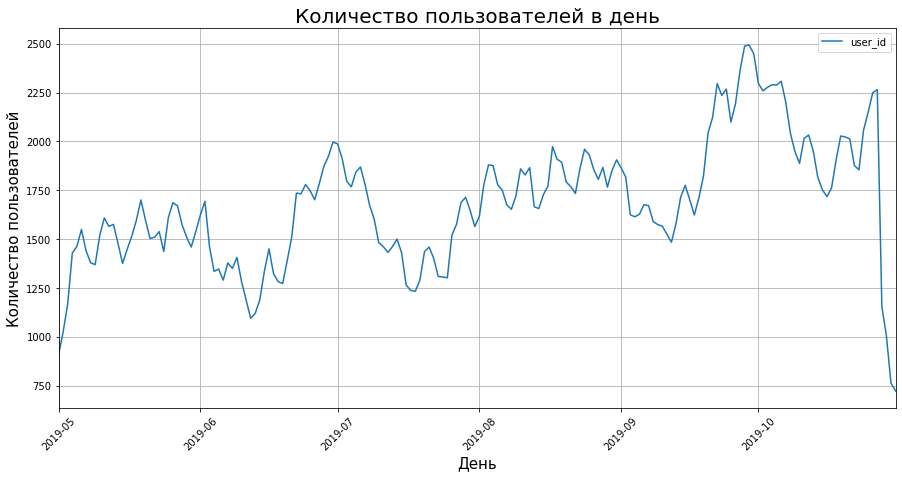

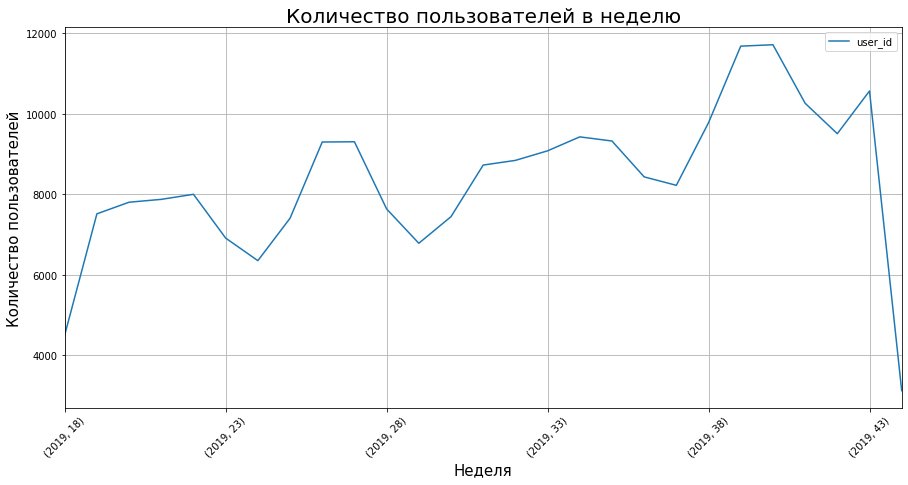

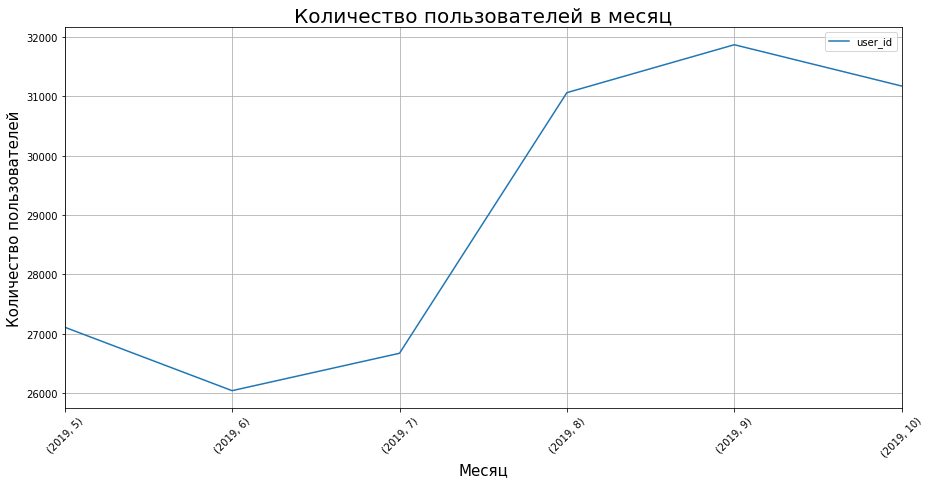

In [16]:
# построение графиков динамики DAU, WAU и MAU
plot_metrics(dau_total,"Количество пользователей в день","День","Количество пользователей")
plot_metrics(wau_total,"Количество пользователей в неделю","Неделя","Количество пользователей")
plot_metrics(mau_total,"Количество пользователей в месяц","Месяц","Количество пользователей")

**Вывод:**
* По графикам видно, что количество пользователей в день, неделю  и месяц колеблется на протяжение исследуемого периода, но в целом тенденция положительная, количество пользователей приложения растёт.
* На графиках динамики количества пользователей в день и неделю есть резкие спады в конце рассматриваемого периода, вероятно, это связано с тем, что данные за последний день и неделю неполные, так что не будем обращать на это внимание.

* **Сколько сессий в день?**

Расчитаем количество пользовательских сессий в день. Для этого сгруппируем данные по дате, сосчитаем количество уникальных пользоватлей (*n_users*) и количество сессий (*n_sessions*) для каждого дня. Затем разделим количество сессий на количество пользователей, чтобы узнать сколько сессий в среднем приходится на одного пользователя.

,n_sessions,n_users,sessions_per_user
session_date,,,
2019-05-01,909,909,1
2019-05-02,1026,1026,1
2019-05-03,1170,1170,1
2019-05-04,1429,1429,1
2019-05-05,1463,1463,1


Среднее количество сессий в день: 1684


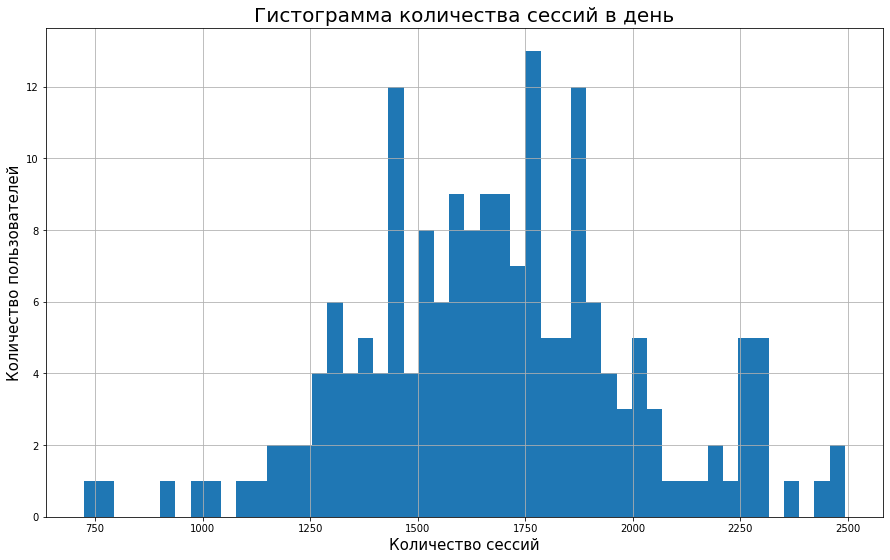

In [17]:
# группировка по столбцу session_date
sessions_per_user = (
    visits.groupby(['session_date'])
    .agg({'user_id':['count','nunique']})
)

sessions_per_user.columns = ['n_sessions','n_users']
sessions_per_user['sessions_per_user'] = (sessions_per_user['n_sessions'] / sessions_per_user['n_users']).astype(int)

display(sessions_per_user.head())
print('Среднее количество сессий в день:',int(sessions_per_user['n_sessions'].mean()))

# строим гистограмму
sessions_per_user['n_sessions'].hist(bins=50, figsize=(15,9))
plt.title("Гистограмма количества сессий в день",fontsize=20)
plt.ylabel("Количество пользователей",fontsize=15)
plt.xlabel("Количество сессий",fontsize=15)
plt.show()

**Вывод:**
Каждый пользователь заходит в приложение только один раз в день. 
Среднее количество сессий в день по всем пользователям: 1684

-    **Сколько длится одна сессия?**

Посчитаем продолжительность каждой сессии в секундах, для этого вычтем из времени конца сессии время начала сессии.

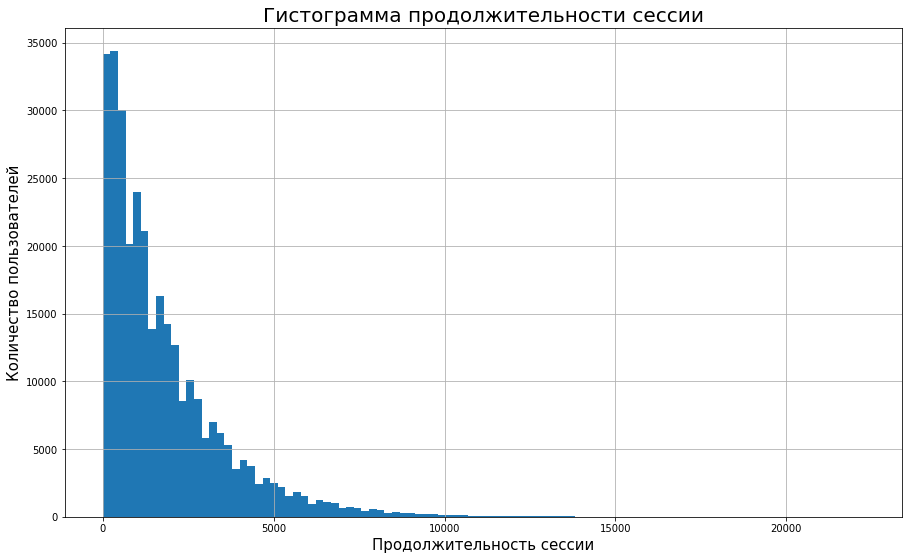

count    309901.000000
mean       1800.084801
std        1803.189827
min           0.000000
25%         540.000000
50%        1260.000000
75%        2520.000000
max       22260.000000
Name: session_duration_sec, dtype: float64

In [18]:
# считаем продолжительность каждой сессии
visits['session_duration_sec'] = (visits['session_end'] - visits['session_start']).dt.seconds

# строим гистограмму
visits['session_duration_sec'].hist(bins=100, figsize=(15,9))
plt.title("Гистограмма продолжительности сессии",fontsize=20)
plt.ylabel("Количество пользователей",fontsize=15)
plt.xlabel("Продолжительность сессии",fontsize=15)
plt.show()

# параметры распределения продолжительности сессий
display(visits['session_duration_sec'].describe())

**Вывод:**
* Медиана более устойчива к выбросам, чем среднее, поэтому будем ориентироваться на неё. Медианная продолжительность сессии **1260 секунд** (21 минута).

#### 3.2.2 Продажи:

- **Когда люди начинают покупать?**

Чтобы рассчитать когда пользователи начинают покупать, добавим в пользовательские профили дату и время первой покупки, затем вычтем из неё время начала первой сессии. Для удобства выведем временной промежуток в днях.

,user_id,first_event_dt,first_ts,first_purchase_duration
0,599326,2019-05-07 20:59:09,2019-05-07 20:58:00,0
1,46006712,2019-06-30 03:46:52,2019-06-30 03:46:00,0
2,374052872,2019-08-16 07:44:47,2019-08-08 15:42:00,7
3,414791703,2019-05-04 18:06:41,2019-05-03 12:01:00,1
4,785077127,2019-06-30 18:35:15,2019-06-27 08:31:00,3


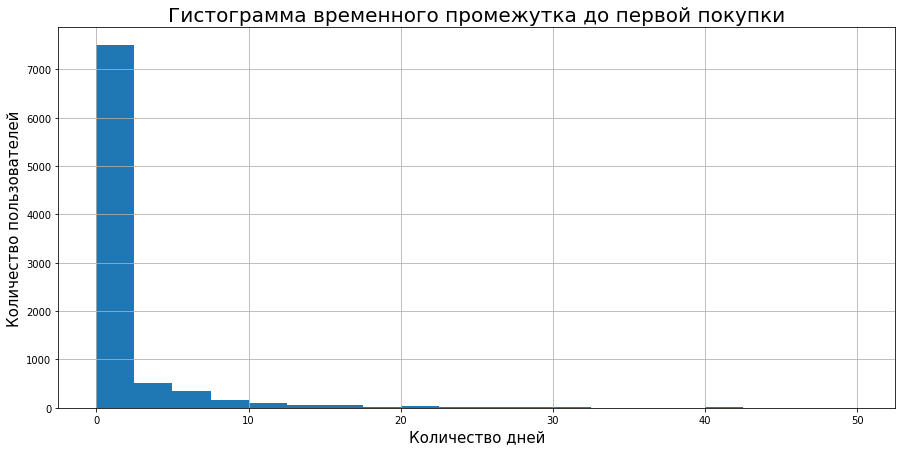

count    8881.000000
mean        1.702511
std         5.944318
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max       132.000000
Name: first_purchase_duration, dtype: float64

In [19]:
# вывод даты первой покупки для каждого пользователя и добавление в профили
orders_uni = (
    orders.sort_values(by = ['user_id','event_dt'])
    .groupby('user_id')
    .agg({'event_dt':'first'})
    .rename(columns={'event_dt':'first_event_dt'})
    .merge(profiles[['user_id','first_ts']], on='user_id',how='left')
)

# расчёт временного промежутка до момента первой покупки в днях
orders_uni['first_purchase_duration'] = (orders_uni['first_event_dt'] - orders_uni['first_ts']).dt.days
display(orders_uni.head())

# построение гистограммы
orders_uni['first_purchase_duration'].hist(bins=20, range=(0,50),figsize=(15,7))
plt.title("Гистограмма временного промежутка до первой покупки",fontsize=20)
plt.ylabel("Количество пользователей",fontsize=15)
plt.xlabel("Количество дней",fontsize=15)
plt.show()

orders_uni['first_purchase_duration'].describe()

**Вывод:**
Большинтво пользователей совершает первую покупку в первый же день.

- **Сколько покупок делает в среднем платящий пользователь за месяц, неделю, день?**

In [20]:
# вывод года, месяца, недели и даты покупки
orders['event_dt_year'] = orders['event_dt'].dt.year
orders['event_dt_month'] = orders['event_dt'].dt.month
orders['event_dt_week'] = orders['event_dt'].dt.week
orders['event_dt_date'] = orders['event_dt'].dt.date

orders.head()

,user_id,event_dt,revenue,event_dt_year,event_dt_month,event_dt_week,event_dt_date
0,188246423999,2019-05-01 23:09:52,4.99,2019,5,18,2019-05-01
1,174361394180,2019-05-01 12:24:04,4.99,2019,5,18,2019-05-01
2,529610067795,2019-05-01 11:34:04,4.99,2019,5,18,2019-05-01
3,319939546352,2019-05-01 15:34:40,4.99,2019,5,18,2019-05-01
4,366000285810,2019-05-01 13:59:51,4.99,2019,5,18,2019-05-01


Сгруппируем данные по месяцу, неделе и дню, найдем количество покупок и количество уникальных пользователей для каждой группировки. Заодно посчитаем суммарную выручку за каждый период.

In [21]:
# расчет количества покупок в месяц на уникального пользователя и суммарной выручки за месяц + средний чек
OPM = (orders.groupby('event_dt_month')
       .agg({'user_id':['count','nunique'],'revenue':['sum','mean']}))

OPM.columns = ['n_purchase','n_users','sum_revenue','mean_revenue']
OPM['orders_per_month'] = round(OPM['n_purchase'] / OPM['n_users'],2)
OPM['sum_revenue'] = round(OPM['sum_revenue'],2)

# расчет количества покупок в неделю на уникального пользователя и суммарной выручки за неделю + средний чек
OPW = (orders.groupby('event_dt_week')
       .agg({'user_id':['count','nunique'],'revenue':['sum','mean']}))

OPW.columns = ['n_purchase','n_users','sum_revenue','mean_revenue']
OPW['orders_per_week'] = round(OPW['n_purchase'] / OPW['n_users'],2)
OPW['sum_revenue'] = round(OPW['sum_revenue'],2)

# расчет количества покупок в день на уникального пользователя и суммарной выручки за день + средний чек
OPD = (orders.groupby('event_dt_date')
       .agg({'user_id':['count','nunique'],'revenue':['sum','mean']}))

OPD.columns = ['n_purchase','n_users','sum_revenue','mean_revenue']
OPD['orders_per_day'] = round(OPD['n_purchase'] / OPD['n_users'],2)
OPD['sum_revenue'] = round(OPD['sum_revenue'],2)

# расчет среднего количества покупок в день/неделю/месяц
OPM_mean = round(OPM['orders_per_month'].mean(),2)
OPW_mean = round(OPW['orders_per_week'].mean(),2)
OPD_mean = round(OPD['orders_per_day'].mean(),2)

display(OPM)
display(OPW.head())
display(OPD.head())

print('Среднее количество покупок в месяц:',OPM_mean)
print('Среднее количество покупок в неделю:',OPW_mean)
print('Среднее количество покупок в день:',OPD_mean)

,n_purchase,n_users,sum_revenue,mean_revenue,orders_per_month
event_dt_month,,,,,
5,2962,1226,15787.38,5.329973,2.42
6,4875,2130,26428.25,5.421179,2.29
7,6556,2801,35988.44,5.489390,2.34
8,7582,3476,40401.18,5.328565,2.18
9,8430,4124,44941.70,5.331163,2.04
10,9807,4670,52415.93,5.344747,2.10


,n_purchase,n_users,sum_revenue,mean_revenue,orders_per_week
event_dt_week,,,,,
18,212,156,1156.88,5.456981,1.36
19,568,372,3061.32,5.389648,1.53
20,706,466,3731.94,5.286034,1.52
21,808,574,4170.92,5.162030,1.41
22,982,698,5349.18,5.447230,1.41


,n_purchase,n_users,sum_revenue,mean_revenue,orders_per_day
event_dt_date,,,,,
2019-05-01,25,25,125.75,5.030000,1.0
2019-05-02,29,29,144.71,4.990000,1.0
2019-05-03,44,44,221.56,5.035455,1.0
2019-05-04,56,56,327.44,5.847143,1.0
2019-05-05,58,58,337.42,5.817586,1.0


Среднее количество покупок в месяц: 2.23
Среднее количество покупок в неделю: 1.33
Среднее количество покупок в день: 1.0


In [22]:
# функция для построения графиков
def plot_metrics2(data,y,title,xlabel,ylabel):
    data.plot(y=y, figsize=(15,7),grid=True)
    plt.title(title,fontsize=20)
    plt.ylabel(xlabel,fontsize=15)
    plt.xlabel(ylabel,fontsize=15)
    plt.show()

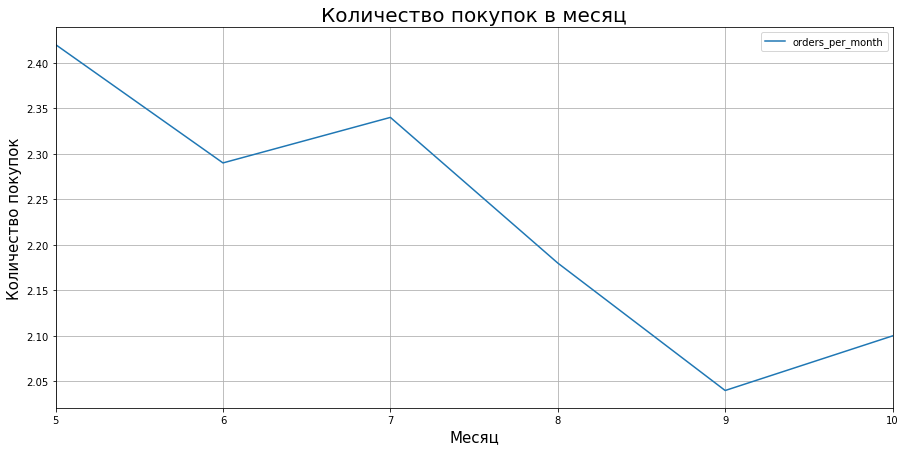

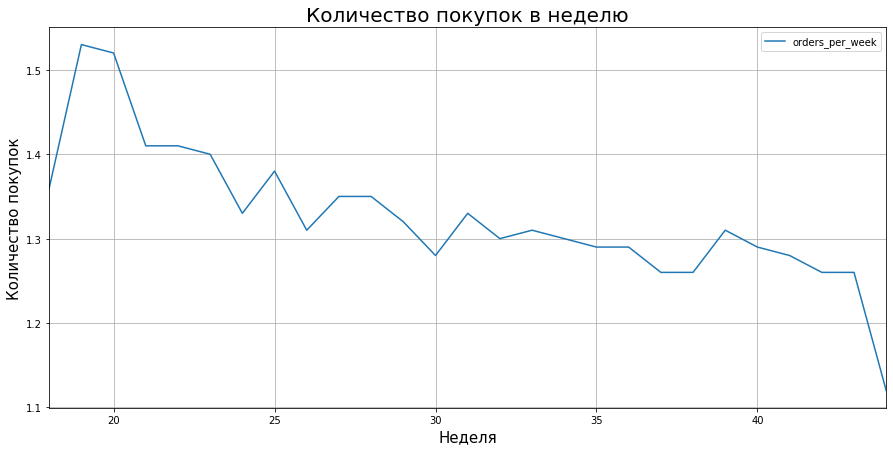

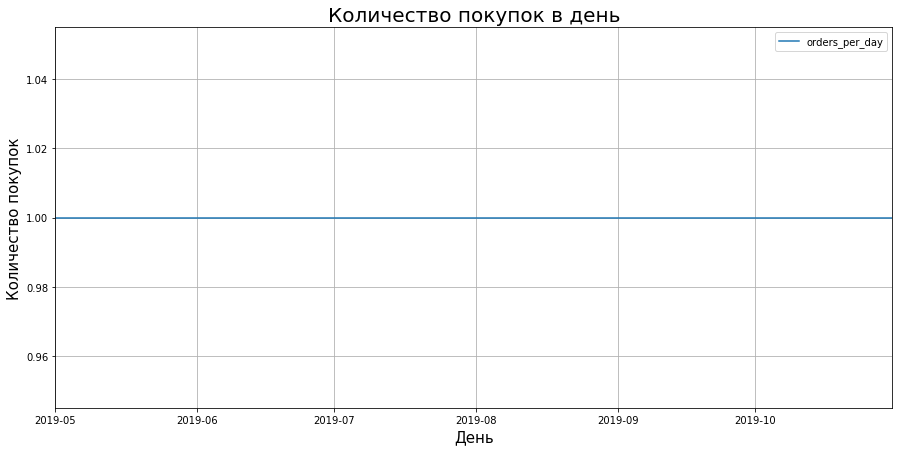

In [23]:
# построение графиков
plot_metrics2(OPM,'orders_per_month',"Количество покупок в месяц","Количество покупок","Месяц")
plot_metrics2(OPW,'orders_per_week',"Количество покупок в неделю","Количество покупок","Неделя")
plot_metrics2(OPD,'orders_per_day',"Количество покупок в день","Количество покупок","День")

**Вывод:** Из графиков видно, что среднее количество покупок немного уменьшилось.

- **Какой средний чек за месяц, неделю, день?**

В предыдущем разделе мы уже рассчитали средний чек для каждого месяца, недели и дня. Теперь построим графики.

In [24]:
print('Средняя сумма покупок в месяц:',round(OPM['sum_revenue'].mean(),2))
print('Средняя сумма покупок в неделю:',round(OPW['sum_revenue'].mean(),2))
print('Средняя сумма покупок в день:',round(OPD['sum_revenue'].mean(),2))

Средняя сумма покупок в месяц: 35993.81
Средняя сумма покупок в неделю: 7998.63
Средняя сумма покупок в день: 1173.71


In [25]:
print('Средний чек в месяц:',round(OPM['mean_revenue'].mean(),2))
print('Средний чек в неделю:',round(OPW['mean_revenue'].mean(),2))
print('Средний чек в день:',round(OPD['mean_revenue'].mean(),2))

Средний чек в месяц: 5.37
Средний чек в неделю: 5.38
Средний чек в день: 5.38


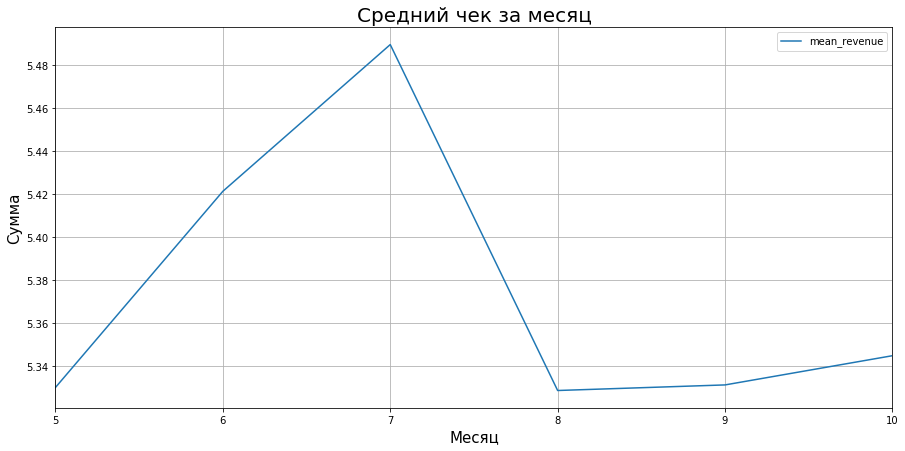

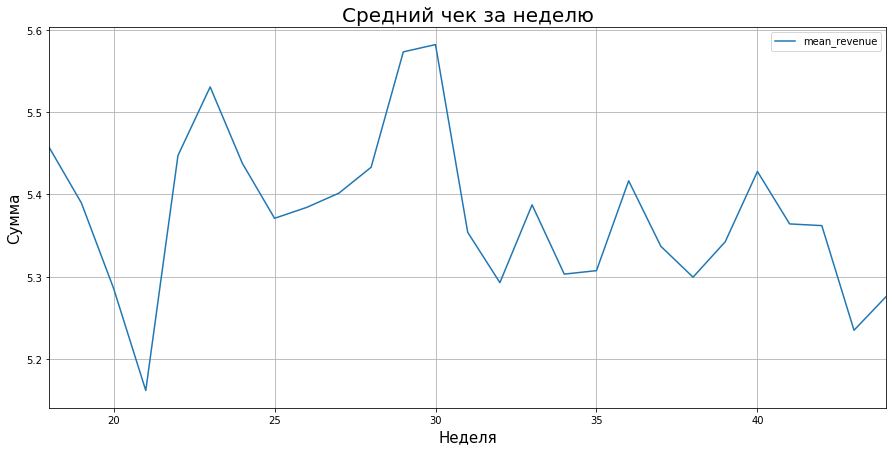

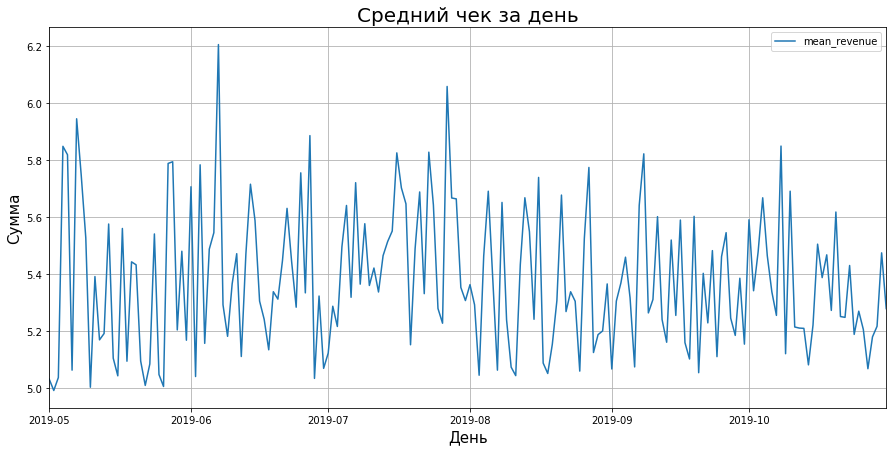

In [26]:
plot_metrics2(OPM,'mean_revenue',"Средний чек за месяц","Cумма","Месяц")
plot_metrics2(OPW,'mean_revenue',"Средний чек за неделю","Сумма","Неделя")
plot_metrics2(OPD,'mean_revenue',"Средний чек за день","Сумма","День")

**Вывод:**
Графики показывают, что пользователи за последние полгода стали оставлять меньше денег в приложении.

#### 3.2.3 Маркетинг:

- **Сколько денег потратили? Всего / на каждый источник / по времени**

Посчитаем сколько всего денег было потрачено на рекламу:

In [27]:
total_cost = round(costs['costs'].sum(),2)
print('Суммарные затраты на рекламу:', total_cost)

Суммарные затраты на рекламу: 105497.3


Сгруппируем данные по рекламным каналам и посчитаем сумму затрат на каждый из них.

In [28]:
costs.groupby('channel').agg({'costs':'sum'}).sort_values(by='costs',ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [29]:
costs['month'] = costs['dt'].dt.month
costs['week'] = costs['dt'].dt.week

Сгруппируем данные по рекламным каналам и посмотрим, как менялись затраты на рекламу по месяцам и неделям:

In [30]:
channel_month = costs.groupby(['channel','month'],as_index=False).agg({'costs':'sum'})
channel_week = costs.groupby(['channel','week'],as_index=False).agg({'costs':'sum'})
display(channel_month.head(),channel_week.head())

,channel,month,costs
0,AdNonSense,5,1169.70
1,AdNonSense,6,538.65
2,AdNonSense,7,504.00
3,AdNonSense,8,579.60
4,AdNonSense,9,581.70


,channel,week,costs
0,AdNonSense,18,211.05
1,AdNonSense,19,273.00
2,AdNonSense,20,265.65
3,AdNonSense,21,266.70
4,AdNonSense,22,202.65


Построим графики:

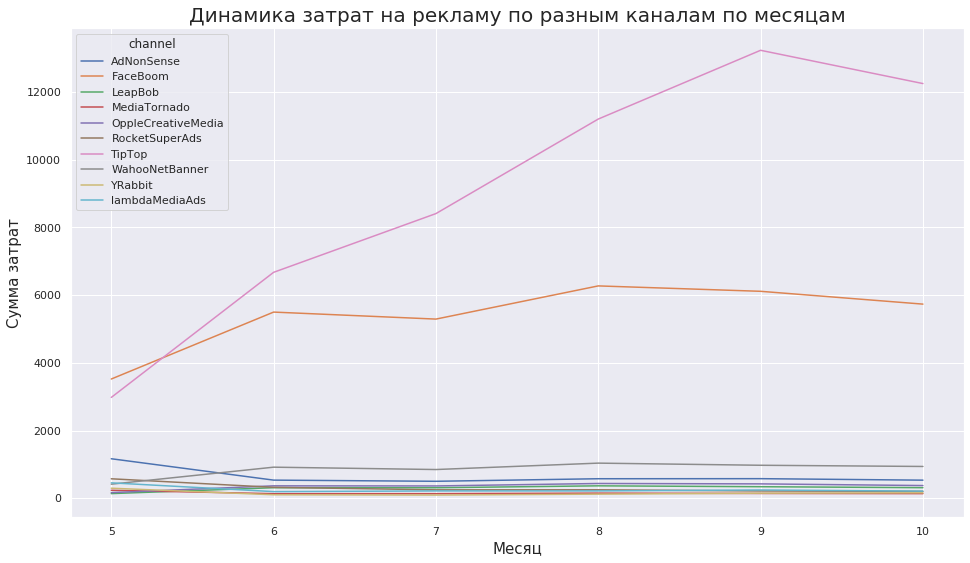

In [31]:
plt.figure(figsize=(16,9))
sns.set_theme()
sns.lineplot(x='month',y='costs',data=channel_month,hue='channel')
plt.title("Динамика затрат на рекламу по разным каналам по месяцам", fontsize = 20)
plt.xlabel("Месяц", fontsize = 15)
plt.ylabel("Сумма затрат", fontsize = 15)
plt.show()

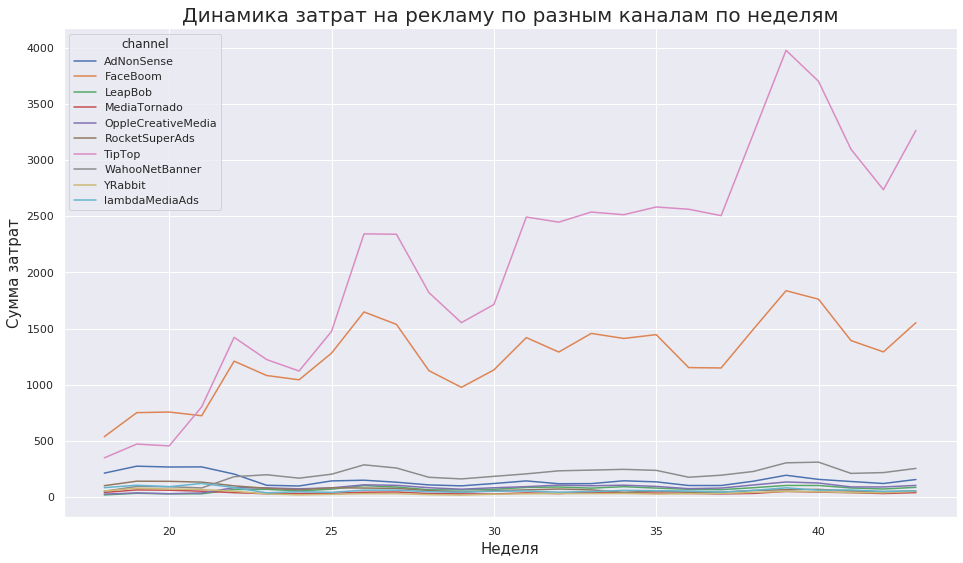

In [32]:
plt.figure(figsize=(16,9))
sns.set_theme()
sns.lineplot(x='week',y='costs',data=channel_week,hue='channel')
plt.title("Динамика затрат на рекламу по разным каналам по неделям", fontsize = 20)
plt.xlabel("Неделя", fontsize = 15)
plt.ylabel("Сумма затрат", fontsize = 15)
plt.show()

Сгруппируем данные по месяцу и неделе и расчитаем общие затраты на рекламу:

In [33]:
costs_month = costs.groupby('month').agg({'costs':'sum'})
costs_week = costs.groupby('week').agg({'costs':'sum'})

display(costs_month, costs_week.head(10))

,costs
month,
5,9978.570
6,15090.045
7,16447.060
8,20657.870
9,22441.340
10,20882.415


,costs
week,
18,1455.640
19,2031.820
20,1976.320
21,2297.120
22,3427.075
23,2915.740
24,2706.390
25,3421.390
26,4837.120


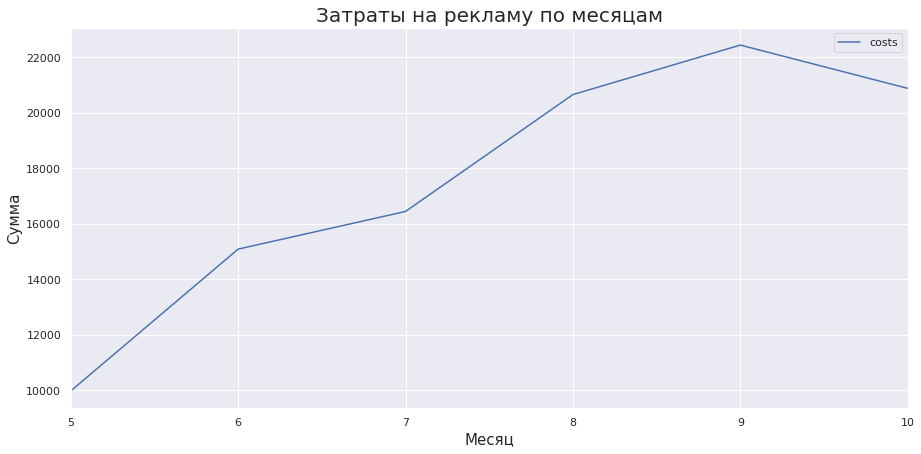

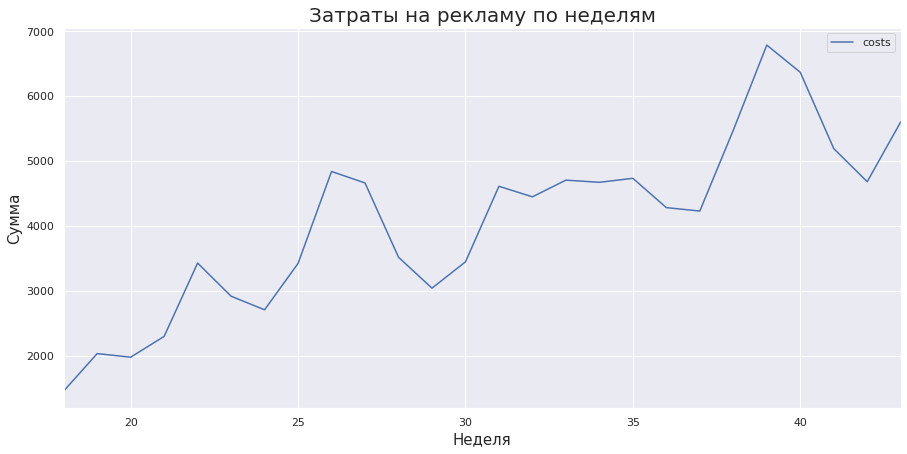

In [34]:
# построим графики
plot_metrics2(costs_month,'costs',"Затраты на рекламу по месяцам","Cумма","Месяц")
plot_metrics2(costs_week,'costs',"Затраты на рекламу по неделям","Сумма","Неделя")

**Вывод:**
По графикам видно, что затраты на рекламу растут, при этом пользователи оставляют в приложении всё меньше денег. Из графиков с разбивкой по каналам видно, что затраты на канал TipTop сильно возросли, затраты на FaceBoom возросли меньше, а на остальные каналы не изменились вообще.

- **Сколько в среднем стоило привлечение одного пользователя из каждого источника?**

In [35]:
# преобразуем данные о времени
costs['dt'] = costs['dt'].dt.date

costs.head(5)

,dt,channel,costs,month,week
0,2019-05-01,FaceBoom,113.3,5,18
1,2019-05-02,FaceBoom,78.1,5,18
2,2019-05-03,FaceBoom,85.8,5,18
3,2019-05-04,FaceBoom,136.4,5,18
4,2019-05-05,FaceBoom,122.1,5,18


Добавим расчёт CAC (Стоимость привлечения одного пользователя) в пользовательские профили.

In [36]:
# добавляем параметр ad_costs — траты на рекламу
def get_profiles2(sessions, orders, ad_costs):

    # сортируем сессии по ID пользователя и дате привлечения
    # группируем по ID и находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
         # время первого посещения назовём first_ts
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
         # столбец с числом пользователей назовём unique_users
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()  # возвращаем dt и channel из индексов
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    # по дате и каналу привлечения
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    # результаты сохраним в столбец acquisition_cost (CAC)
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавим стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # органические пользователи не связаны с данными о рекламе,
    # поэтому в столбце acquisition_cost у них значения NaN
    # заменим их на ноль, ведь стоимость привлечения равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    
    return profiles  # возвращаем профили с CAC

In [37]:
# создаём профили с новым параметром acquisition_cost
profiles_cac = get_profiles2(visits, orders, costs)
profiles_cac.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:00,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:00,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:00,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:00,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:00,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [38]:
# считаем средний CAC по всему проекту
cac_mean = profiles_cac.query('acquisition_cost != 0')['acquisition_cost'].mean()
cac_mean

1.1274813239427588

In [39]:
# считаем средний CAC по каналам привлечения

cac_channel = (
    profiles_cac.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
)

cac_channel

,cac
channel,
AdNonSense,1.008054
FaceBoom,1.113286
LeapBob,0.210172
MediaTornado,0.218717
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
TipTop,2.799003
WahooNetBanner,0.602245
YRabbit,0.218975


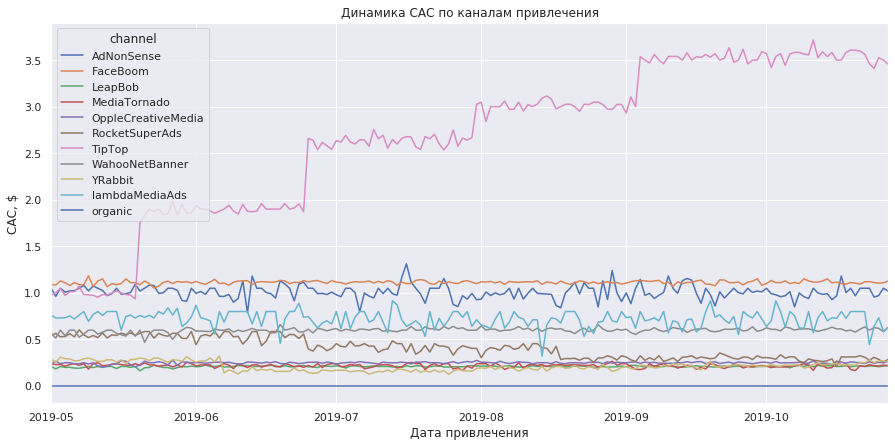

In [40]:
# строим график истории изменений CAC по каналам привлечения

profiles_cac.pivot_table(
    index='dt', columns='channel', values='acquisition_cost', aggfunc='mean'
).plot(grid=True, figsize=(15, 7))
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

**Вывод:**
По графику динамики CAC с разбивкой по каналам привлечения видно, что стоимость привлечения клиентов стабильна для всех каналов, кроме **TipTop**. Стоимость привлечения пользователей через этот канал выросла за полгода больше, чем в 3 раза. На этот канал компания тратит больше всего средств, почти в 2 раза больше чем на FaceBoom, через который, как мы выяснили ранее, приходит большинство пользователей.

### Вывод по разделу

В данном разделе было выявлено, что:

* Количество пользователей приложения стабильно росло в течение рассматриваемого периода
* Пользователи стабильно заходят в приложение раз в день
* Сессия в среднем длится 1260 секунд (21 минута)
* Большинство пользователей совершают покупку в первый день использования приложения
* Среднее количество покупок в месяц стабильно и не изменилось за рассматриваемый период
* Средний чек сильно уменьшился за рассматриваемые полгода
* Затраты на рекламу приложения существенно выросли, это связано с тем, что стоимоть привлечения клиентов через канал TipTop по каким-то причинам выросла в 3.5 раза.

# 4. Определение функций для расчета и анализа LTV, ROI, удержания и конверсии


Определим функции для расчёта LTV,ROI, удержания и конверсии а также визуализации показателей.

In [41]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [42]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [43]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [44]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [45]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [46]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [47]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

# 5. Оценка окупаемости рекламы для привлечения пользователей

Расчитаем LTV и ROI и проанализируем результаты. Узнаем, окупается ли реклама в целом и в разбивке по источникам привлечения, странам и устройствам.

### 5.1 Общая окупаемость рекламы

Зададим момент и горизонт анализа.

In [48]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

Проанализируем общую окупаемость рекламы. Посчитаем LTV и ROI:

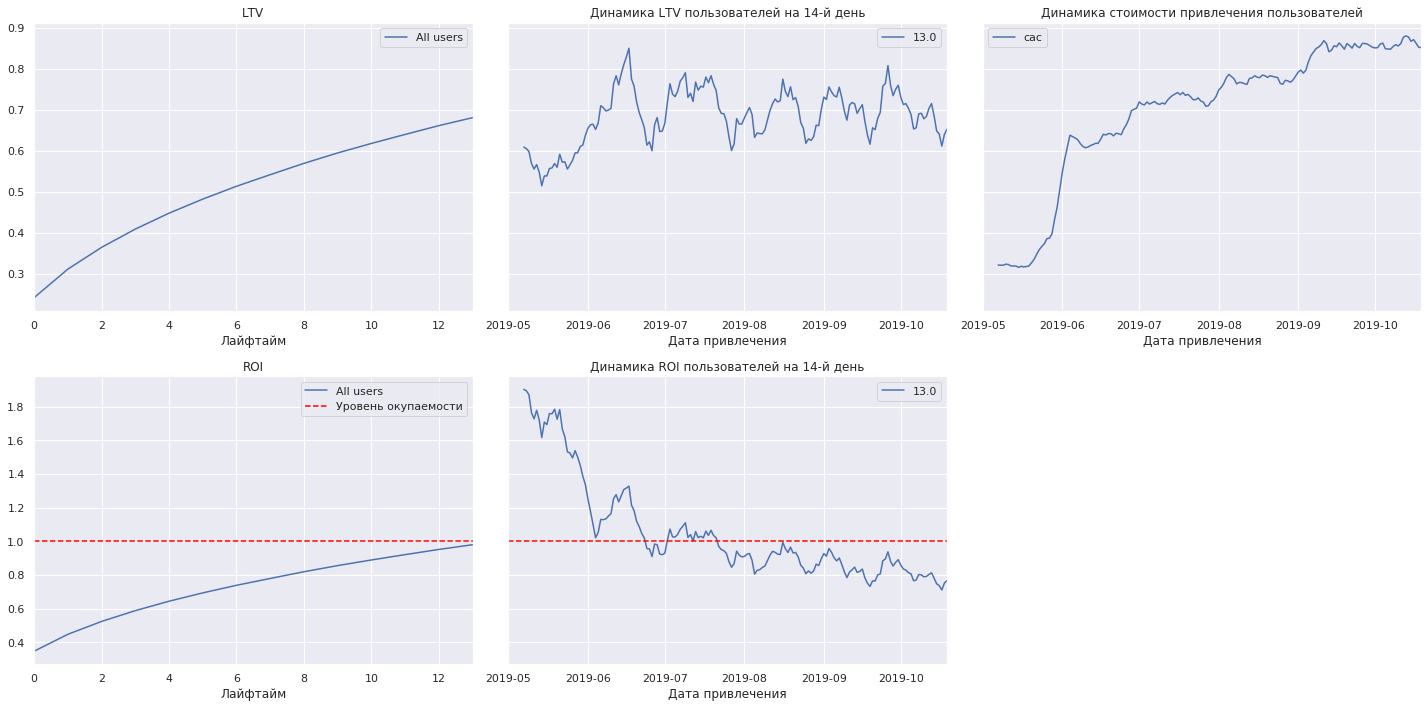

In [49]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_cac, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Из графиков видно, что:
* Реклама окупается только на 14 день, ROI выходит в ноль, следовательно, реклама не приносит прибыли.
* На LTV скорее всего влияет сезонный фактор, но в целом показатель достаточно стабилен. 
* А вот CAC сильно вырос в течение рассматриваемого периода. Ранее мы уже выяснили, что в этом виноват канал TipTop.

### 5.2 Окупаемость рекламы с разбивкой по устройствам

Посчитаем LTV и ROI с разбивкой по устройствам:

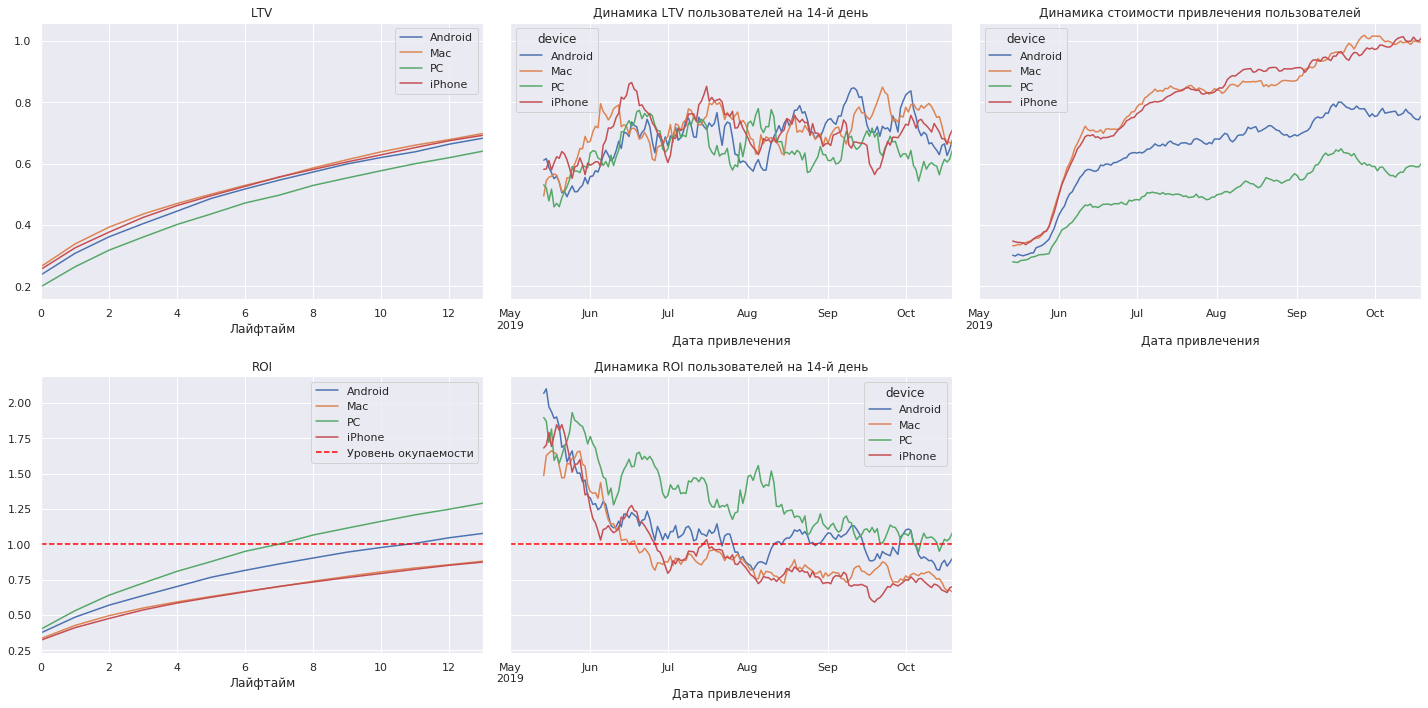

In [50]:
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_cac, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

* LTV по-прежнему стабилен. Значит, дело не в качестве пользователей, которые используют какое-то конкретное устройство.
* Для Android и PC реклама окупается и даже приносит прибыль, а вот для Mac и iPhone реклама не окупается совсем.
* За весь период CAC вырос для всех устройств, но больше всего как раз для Mac и iPhone.
* Динамика ROI на 14 день показывает, что реклама для Mac и iPhone перестала окупаться еще в конце июня, а в начале ноября перестала окупаться и для Android.

### 5.3 Окупаемость рекламы с разбивкой по странам

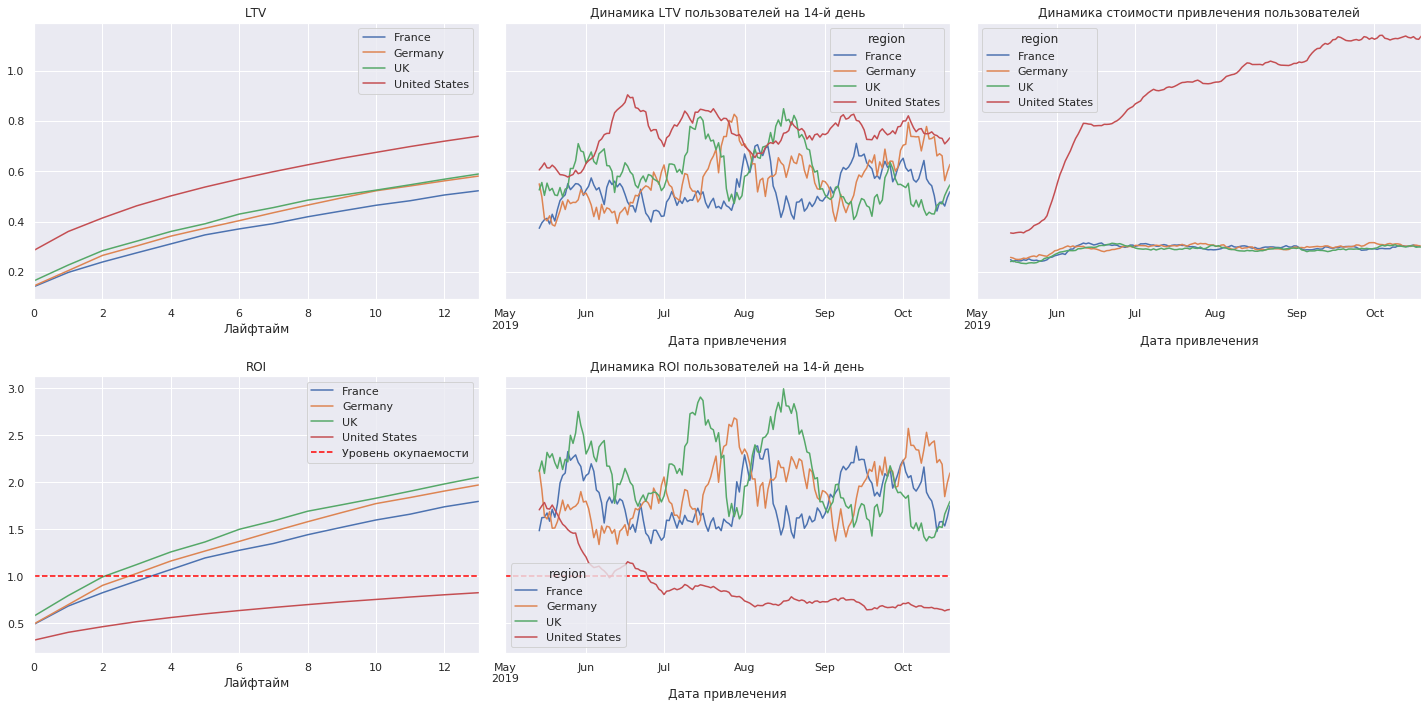

In [51]:
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_cac, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

* У пользователей из США, самый высокий LTV, по идее эти пользователи должны приносить компании самую высокую прибыль, однако из графика динамики CAC видно, что стоимость привлечения пользователей как раз выросла в несколько раз именно для этого региона, а для остальных CAC стабилен. Также видим, что реклама не окупается только для пользователей из США.

### 5.4 Окупаемость рекламы с разбивкой по рекламным каналам

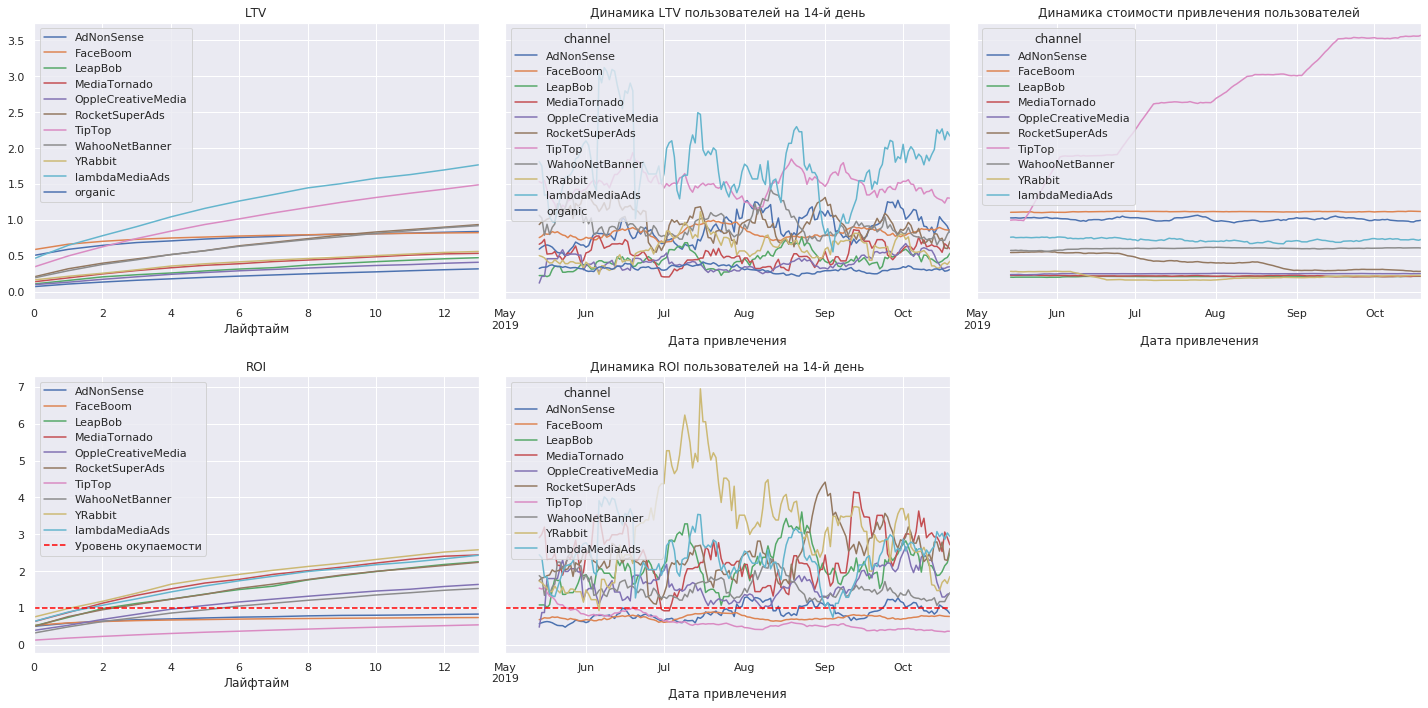

In [52]:
# смотрим окупаемость с разбивкой по рекламным каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_cac, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

* Ещё раз убеждаемся, что TipTop, как раз тот самый канал, чья стоимость сильно выросла и из-за которого вероятно, начились все проблемы. Также видим, что реклама через FaceBoom также не окупается, хоть стоимость привлечения клиентов через него и не изменилась. На это также стоит обратить внимание, так как это самый крупный канал привлечения клиентов для компании.

### 5.5 Удержание и коверсии

Расчитаем общее удержание пользователей без разбивки по дополнительным признакам:

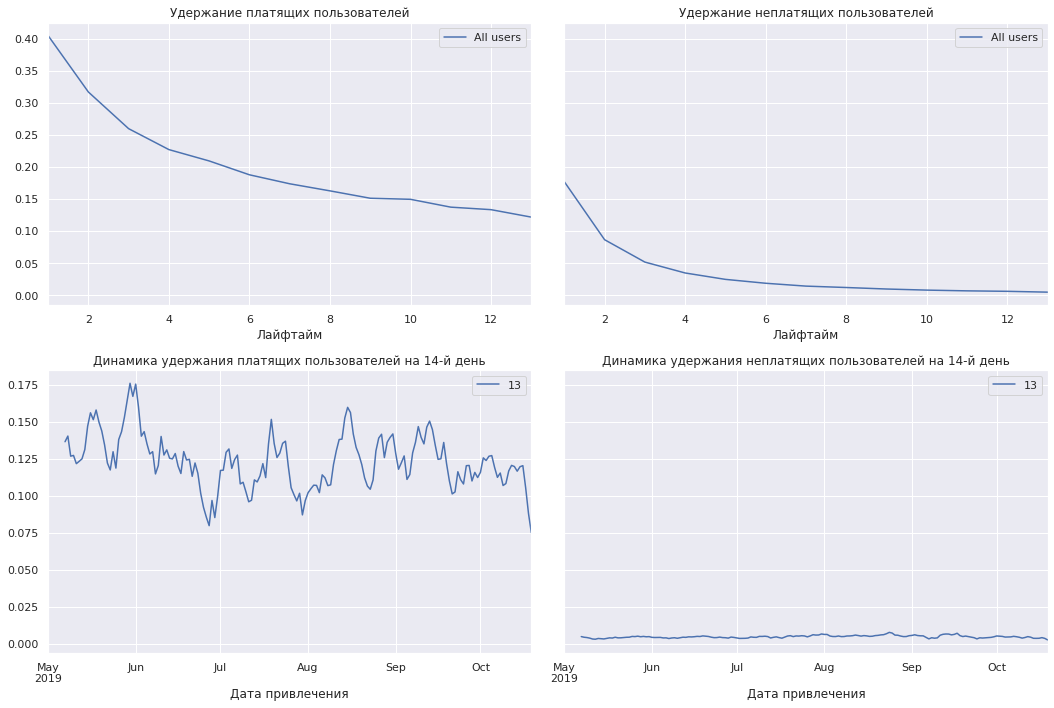

In [53]:
# смотрим удержание 
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_cac, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание платящих пользователей стабильно больше, чем удержание неплатящих, так и должно быть.

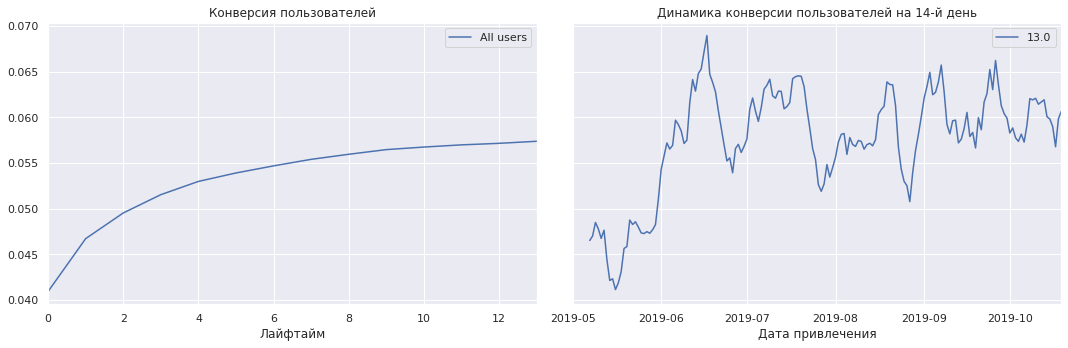

In [54]:
# смотрим конверсию 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Общая динамика конверсий тоже выглядит неплохо, пользователе стабильно конвертируются.
Рассмотрим удержание и конверсии в разбивке по устройствам, регионам и рекламным каналам.

#### Удержание и конверсии в разбивке по рекламным каналам

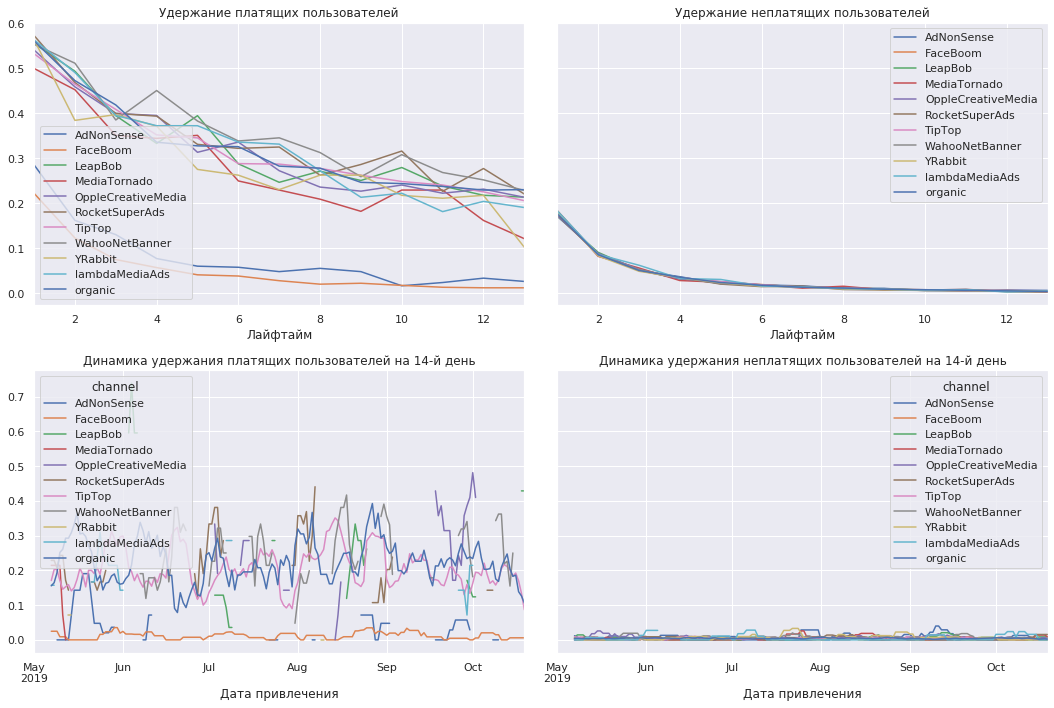

In [55]:
dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_cac, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)


Видно, что с удержанием пользователей, привлеченных через TipTop проблем нет - они удерживаются хорошо и стабильно. А вот с пользователями FaceBoom и AdNonSence есть проблемы - удержание очень низкое.

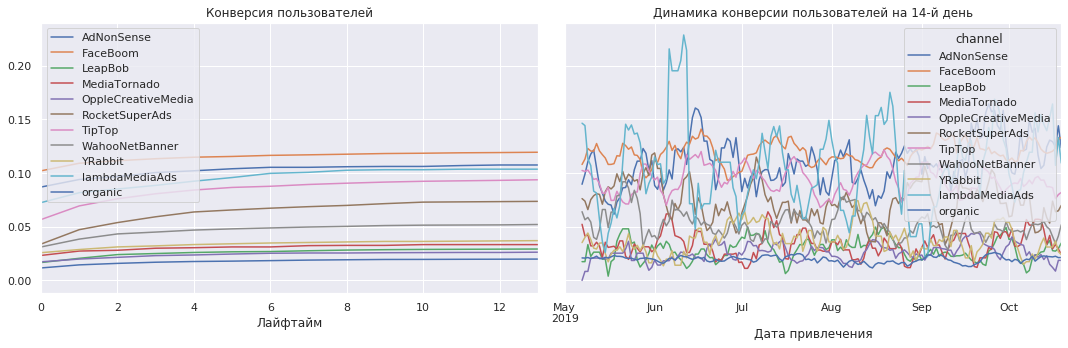

In [56]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

С конверсиями пользователей интересующих нас рекламных каналов проблем нет, пользователи стабильно и хорошо конвертируются. Конверсии по FaceBoom вообще самые высокие.

#### Удержание и конверсии в разбивке по устройствам

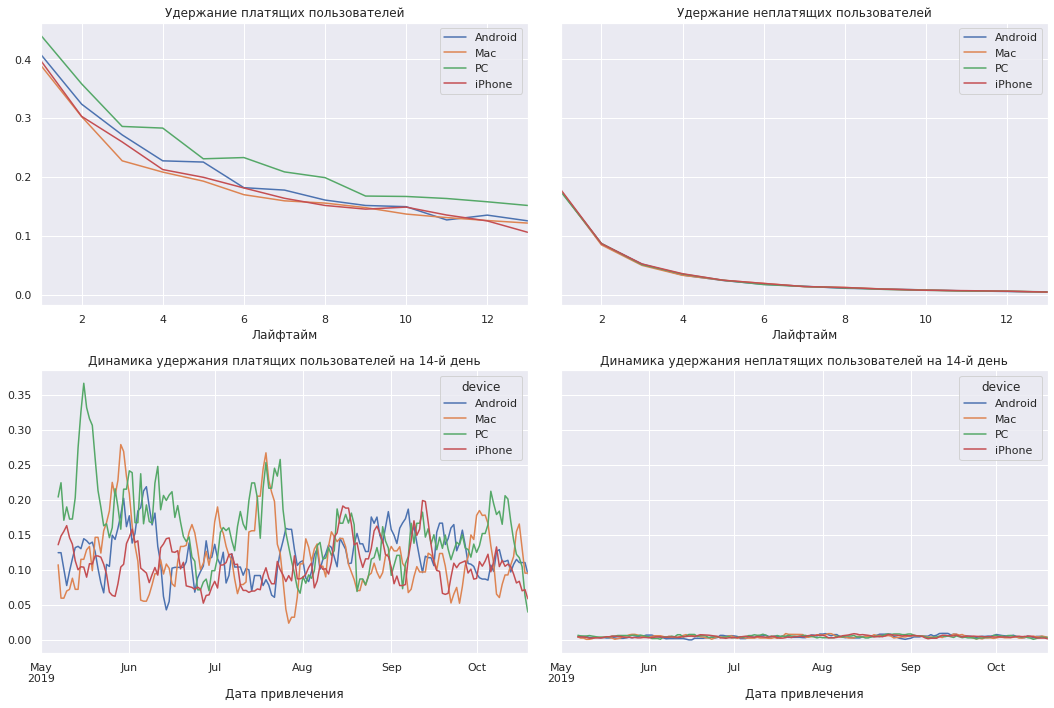

In [57]:
dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_cac, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)


В разбивке по устройствам тоже проблем не наблюдается, самое высокое удержание у пользователей PC.

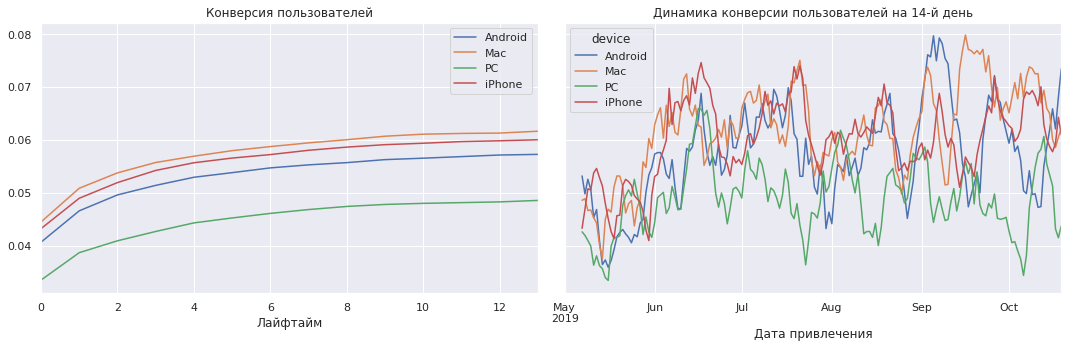

In [58]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

А вот конверсии у пользователей PC самые низкие.

#### Удержание и конверсии в разбивке по регионам

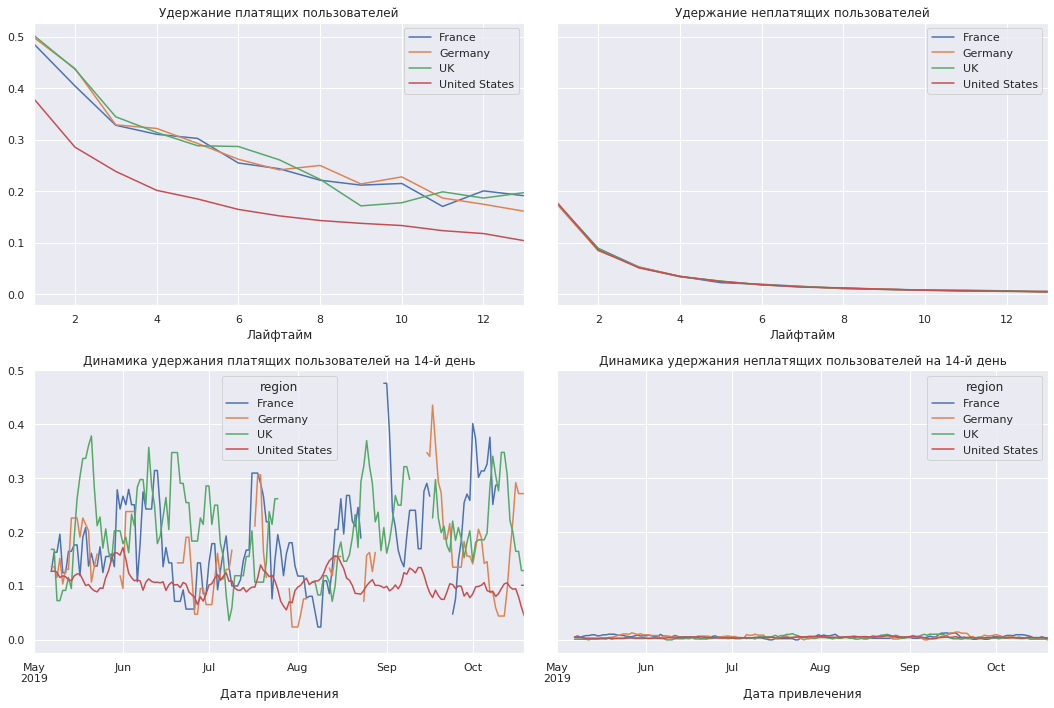

In [59]:
dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_cac, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

У пользователей из США самое низкое удержание, для всех остальных регионов удержание на стабильно высоком уровне.

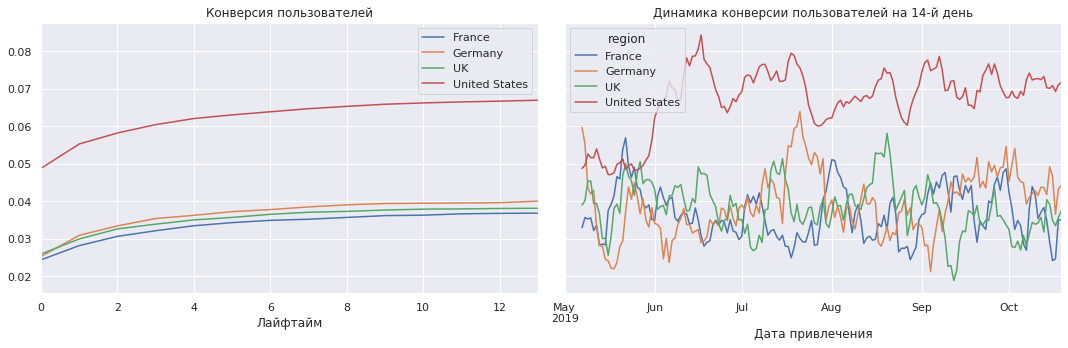

In [60]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

При этом, конверсии в США наоборот лидируют. Значит, пользователи из США очень охотно заходят в приложение, но по каким-то причинам быстро отваливаются.

Дополнительно посмотрим, какие рекламные каналы используются в разных регионах и как много пользователей из них приходит.

United States


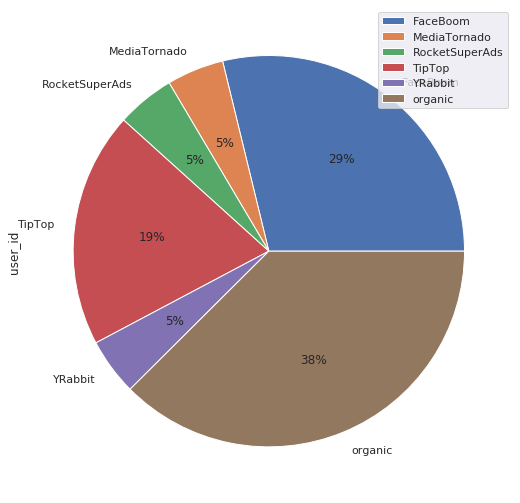

UK


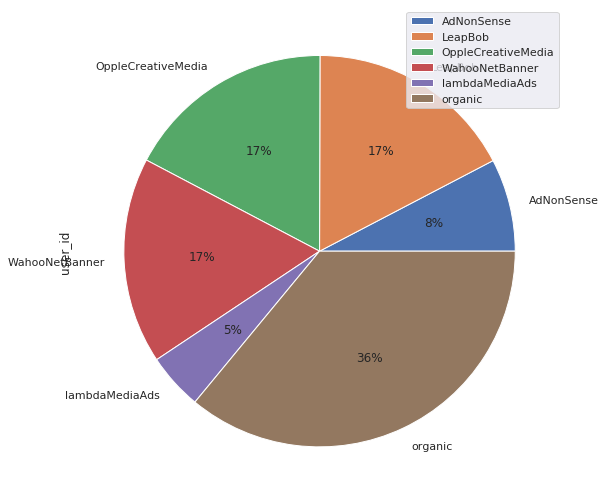

France


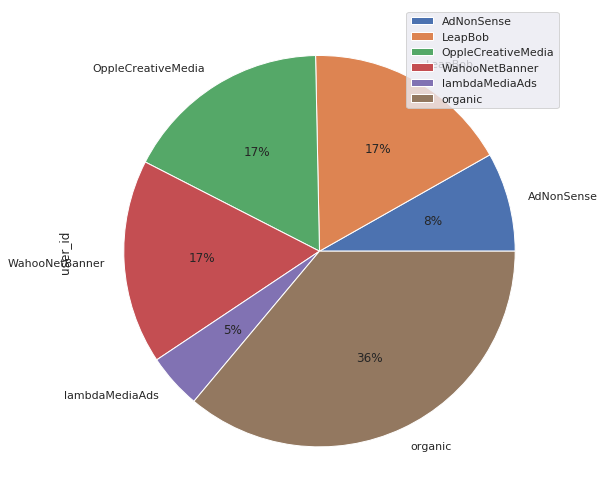

Germany


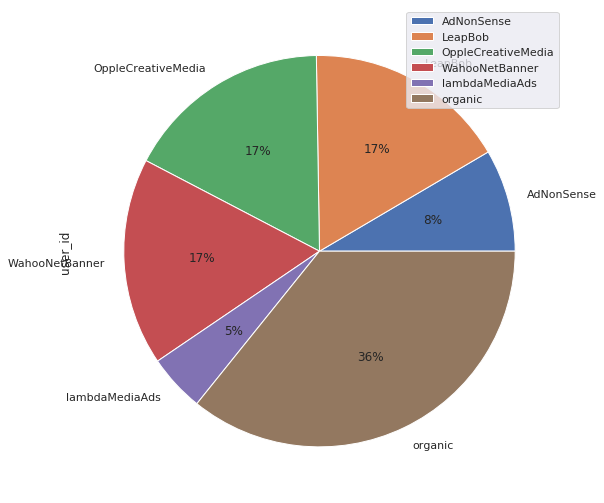

In [61]:
for i in visits['region'].unique():
    print(i)
    (visits[visits['region'] == i].groupby('channel')
     .agg({'user_id':'nunique'})
     .plot(y='user_id',kind='pie',figsize=(16,9),autopct='%1.f%%'))
    plt.show()

Самые проблемные каналы TipTop и FaceBoom используют только для привлечения клиентов из США, причем именно они привлекают большинство клиентов. Совпадение? Не думаю.

## 6. Общие выводы

В ходе расследования было выявлено два проблемных рекламных канала: **TipTop** и **FaceBoom**. Оба ориентированы на пользователей из США - основную и самую обширную аудиторию приложения.
Причём проблемы этих каналов радикально разные.

Пользователи, пришедшие из канала **TipTop** хорошо и конвертируются и также хорошо и стабильно удерживаются. Проблема в том, что стоимость привлечения пользователей через **TipTop** за рассмотренный период выросла в 3.5 раза, в этом и есть причина того, что реклама не окупается и компания терпит убытки. У нас нет данных, чтобы разобраться, почему это произошло, однако маркетологам нужно срочно обратить на это внимание. Необходимо либо каким-то образом изменить рекламную кампанию для этого канала, чтобы она привлекала больше платящих пользователей, либо отказаться от его использования вообще.

С пользователями, пришедшими через **FaceBoom** другая беда - стоимость привлечения клиентов не изменилась, пользователи охотно конвертируются, однако не удерживаются. Возможно, рекламная кампания не оправдывают ожиданий пользователей, они охотно заходят в приложение, но не находят там того, что искали. Скорее всего, маркетологам имеет смысл пересмотреть именно рекламную кампанию, с самим каналом **FaceBoom** все в порядке.

Оба рекламных канала ориентированы на пользователей из **США** - самую крупную аудиторию приложения, и являются основной причиной убытков.